# Dispersion Relation of Transverse-field Ising Model and Time Evolution of Wave Packet

This notebook has two parts. 

The first part presents a sample code for computing the dispersion relation of transverse-field ising model, and the numerical results are compared with analytical solutions obtained by Jodan-Wigner and Bogliubov transformation.

The second part presents the time evolution of a Gaussian wave packet on a tight-binding chain with a gradient field, in which we can observe the Bloch oscillation.

# Dispersion Relation of Transverse-filed Ising Model

Here we consider a transverse-field ising model on an N-site ring.

The Hamiltonian is
$$
H = -J\sum_{i=1}^N (g\sigma_i^x+\sigma_i^z\sigma_{i+1}^z), i\in \mathbb{Z}_N
$$

where we take two sets of parameters $J=1, g=1.6$ and $J=1, g=0.6$.

In [1]:
paramList = [(8, 1, 1.6), (8, 1, 0.6), (4, 1, 1.6), (4, 1, 0.6)]

## Basic Bit Operations

First, let's define some basic bit operations for later use.


In [2]:
def countBinOnes(num):
    return bin(num).count('1')

def concatBins(left, right, leftShift=6):
    return (left << leftShift) + right

def splitBins(num, cutFromRight=6):
    return num >> cutFromRight, num % (1 << cutFromRight)

def readBit(num, n):
    return (num & (1 << n)) >> n

def flipBit(num, n):
    return num ^ (1 << n)

def pickBits(num, start, n):
    return (num & ((2 ** n - 1) << start)) >> start

def rotLBit(num, length, n):
    return (pickBits(num, 0, length-n) << n) + (num >> (length-n))

def rotRBit(num, length, n):
    return (pickBits(num, 0, n) << (length - n)) + (num >> n)


## Constructing Hamiltonian and Translation Operator

Now, we counstruct of the Hamiltonian $H$ and Translation Operator $T$ (e.g. $T\ket{10100} = \ket{01001}$).


In [3]:
import numpy as np
from scipy import sparse

def getHT(N, J, g):

    length = 2 ** N

    # Hamiltonian
    HFrom = []
    HTo = []
    HValue = []

    # Translation
    TFrom = []
    TTo = []
    TValue = []

    for fromBasis in range(length):

        # H: off-diagonal
        for pos in range(N):
            HFrom.append(fromBasis)
            HTo.append(flipBit(fromBasis, pos))
            HValue.append(-J * g)

        # H: diagonal
        HFrom.append(fromBasis)
        HTo.append(fromBasis)
        shift = rotLBit(fromBasis, N, 1)
        numDiff = bin(fromBasis ^ shift).count('1')
        HValue.append(-J * (N - numDiff - numDiff))

        # T:
        TFrom.append(fromBasis)
        TTo.append(rotLBit(fromBasis, N, 1))
        TValue.append(1)

    H = sparse.coo_matrix((HValue, (HTo, HFrom)), shape=(length, length)).toarray()
    T = sparse.coo_matrix((TValue, (TTo, TFrom)), shape=(length, length)).toarray()

    return H, T

## Diagonalizing

Since the Hamiltonian admits translational symmetry, we can diagonalize $HT$ to obtain the eigen energies $E(k)$ with their corresponding momentum $k$ simultaneously:
$$
HT\ket{E, k} = Ee^{ik}\ket{E, k}
$$

However, there's a problem regarding the sign of the energy.

But we can make use of the eigenvectors to obtain $E$ and $k$ seperately.

In [4]:
def getDispersion(H, T):
    HTEigVal, HTEigVec = np.linalg.eig(H @ T)
    E = np.real(np.diagonal(HTEigVec.conj().T @ H @ HTEigVec))
    k = np.real(np.angle(np.diagonal(HTEigVec.conj().T @ T @ HTEigVec)))

    return E, k

In [32]:
H, T = getHT(4, 1, 0.6)
H@T-T@H

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

For $(N, J, g) = (8, 1, 1.6), (8, 1, 0.6), (4, 1, 1.6), (4, 1, 0.6)$, we can plot their dispersion relations:

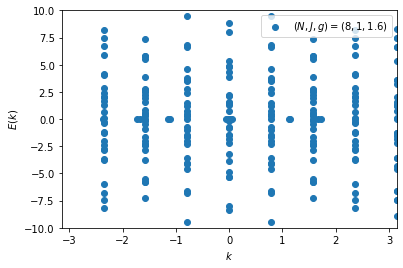

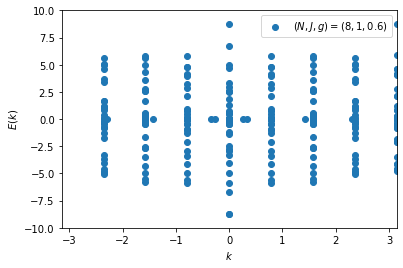

[-7.10401652e+00 -5.77359245e+00 -2.54812662e+00 -1.74961830e+00
 -1.57177220e+00 -1.57177220e+00 -2.45991120e-17  4.25458302e-19
  2.05996816e-17  2.05996816e-17  1.52851144e+00  1.52851144e+00
  1.77359245e+00  2.54812662e+00  5.77073378e+00  7.10401652e+00]


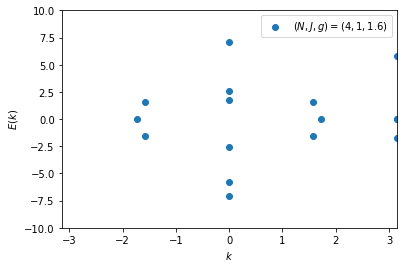

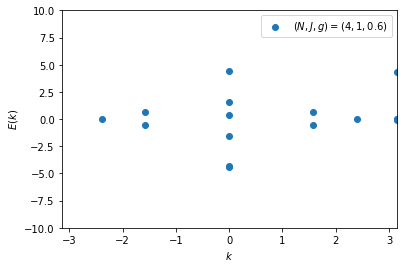

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
for N, J, g in paramList:
    H, T = getHT(N, J, g)
    E, k = getDispersion(H, T)
    if (N, g) == (4, 1.6):
        print(np.sort(E))
    plt.scatter(k, E)
    plt.xlim(-np.pi, np.pi)
    plt.xlabel(r'$k$')
    plt.ylim(-10, 10)
    plt.ylabel(r'$E(k)$')
    plt.legend([f'$(N, J, g)=({N}, {J}, {g})$'])
    plt.show()

## Analytical Solution
The analytical solution can be obtained by applying Jordan-Wigner and Bogliubov transformation.

The result is as follows:
$$
H = \sum_k \epsilon_k \gamma_k^\dagger \gamma_k - \epsilon_0,
$$
where $\gamma_k^\dagger, \gamma_k$ are creation and annihilation operaters of non interaction fermions (at most N of them), and
$$
\epsilon_k = 2J\sqrt{1+g^2-2g\cos{k}},
$$
$$
\epsilon_0 = J\sum_k\sqrt{1+g^2-2g\cos{k}},
$$
summation of k taking $2\pi/N$ times integers for odd number of fermions and half-integers for even number.

In [39]:
def epsilon(J, g, k):
    return J * np.sqrt(1 + g ** 2 - 2 * g * np.cos(k))

In [85]:
def getAnalyticalSol(N, J, g):
    kList=[
        (np.arange(0, N) + 1/2) * 2 * np.pi / N, # even
        np.arange(0, N) * 2 * np.pi / N, # odd
    ]

    E = []
    for config in range(2 ** N):
        energy = 0
        num = bin(config).count('1')
        ks = kList[num % 2]

        energy -= np.sum(epsilon(J, g, ks))
        for pos in range(N):
            if readBit(config, pos):
                print(bin(config), energy)
                energy += 2 * epsilon(J, g, ks[pos])

        E.append(energy)
    return np.array(sorted(E))

## Compare Results
Finally, we can compare the results from exact diagonalization and analytical solution.

In [86]:
for N, J, g in [(2, 1, 1.6), (2, 1, 0.2)]:
    H, T = getHT(N, J, g)
    E, k = getDispersion(H, T)
    E = np.real(np.linalg.eig(H)[0])
    print(H)
    EAS = getAnalyticalSol(N, J, g)
    print(f"Exact Diag.:\n{np.sort(E)}\n Analytical Sol.:\n{EAS}")
    print(f"Whether |ED-AS| < 1e-10:\n{np.abs(np.sort(E)-EAS)<1e-10}")

[[-2.  -1.6 -1.6  0. ]
 [-1.6  2.   0.  -1.6]
 [-1.6  0.   2.  -1.6]
 [ 0.  -1.6 -1.6 -2. ]]
0b1 -3.2
-1.9999999999999996
0b10 -3.2
2.0
0b11 -3.773592452822642
0.0
0b11 0.0
3.773592452822642
Exact Diag.:
[-3.77359245 -2.          2.          3.77359245]
 Analytical Sol.:
[-3.77359245 -2.          2.          3.77359245]
Whether |ED-AS| < 1e-10:
[ True  True  True  True]
[[-2.  -0.2 -0.2  0. ]
 [-0.2  2.   0.  -0.2]
 [-0.2  0.   2.  -0.2]
 [ 0.  -0.2 -0.2 -2. ]]
0b1 -2.0
-0.3999999999999999
0b10 -2.0
0.3999999999999999
0b11 -2.039607805437114
0.0
0b11 0.0
2.039607805437114
Exact Diag.:
[-2.03960781 -2.          2.          2.03960781]
 Analytical Sol.:
[-2.03960781 -0.4         0.4         2.03960781]
Whether |ED-AS| < 1e-10:
[ True False False  True]


In [80]:
epsilon(J, g, 2 * 1/2* np.pi / 2)

1.019803902718557

# Time Evolution of Wave Packet

Now let's consider another problem regarding time evolution.

We put the wave packet in a tight-binding chain with a gradient field:
$$
H = -\sum_{j=1}^N(\ket{j}\bra{j+1} + \ket{j+1}\bra{j}) + F\sum_{j=1}^N\ket{j}\bra{j},
$$
$$
\ket{\psi(t=0)} = \frac{1}{\sqrt{\Omega}}\sum_j e^{-(\alpha^2/2)(j-N_0)^2} e^{ik_0j}\ket{j},
$$
where we choose $N=101, F=0.1, k_0=\pi/2, \alpha=0.15, N_0=51, t\in[0, 100]$.

In [30]:
N = 101; F = 0.1; k0 = np.pi/2; alpha = 0.15; N0 = 51; tmax = 200

In [18]:
# Hamiltonian
length = N

HFrom = []
HTo = []
HValue = []

for fromBasis in range(length):

    if fromBasis != N-1:
        # H: off-diagonal
        HFrom.append(fromBasis+1)
        HTo.append(fromBasis)
        HValue.append(-1)

        HFrom.append(fromBasis)
        HTo.append(fromBasis+1)
        HValue.append(-1)

    # H: diagonal
    HFrom.append(fromBasis)
    HTo.append(fromBasis)
    HValue.append(F * fromBasis)

H = sparse.coo_matrix((HValue, (HTo, HFrom)), shape=(length, length)).toarray()

In [19]:
HEigVal, HEigVec = np.linalg.eig(H)

## State Vector

After obtaining $E_n$ and $\ket{E_n}$, we construct the initial state vector, a Gaussian wave packet.

In [20]:
idx = np.arange(N)
psi0 = np.exp(- alpha ** 2 / 2 * (idx - N0) ** 2) * np.exp(1j * k0 * idx)
# normalize
psi0 = psi0 / np.sqrt(np.abs(psi0))

## Evolution
Now we change basis to $\ket{E_n}$, in which each component evolves independently.

In [21]:
# change basis to E
psi0E = HEigVec.T @ psi0

# evolution
def evolute(psi0E, HEigVal, t):
    return np.exp(-1j * HEigVal * t) * psi0E

In [22]:
prob = np.zeros((tmax, N))
for t in np.arange(0, tmax, 1):
    psitE = evolute(psi0E, HEigVal, t)
    psit = HEigVec @ psitE
    prob[t] = np.abs(psit) ** 2

## Plotting
Finally, we can visualize the evolution by plotting a heatmap.

The horizontal axis represent different site, while the vertical axis represents time.

The probability $|\braket{j|\psi}|^2$ is represented by the color, ranging from 0 to 1.

The Bloch oscillation can be readily seen from the figure.

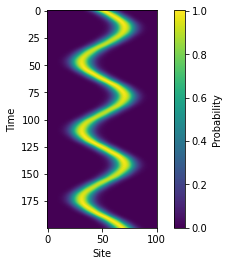

In [23]:
plt.imshow(prob)
plt.xlabel('Site')
plt.ylabel('Time')
plt.colorbar(label='Probability')
plt.show()